<a href="https://colab.research.google.com/github/ManuBansalS/manuS/blob/main/ResearchPaperWork/jupyter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Core libraries
import os, random, re, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# NLP
import nltk, spacy
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Transformers
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

# Visualization
import seaborn as sns

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [2]:
import os
import pandas as pd
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Optional: Still set environment variables for Kaggle if needed elsewhere
os.environ['KAGGLE_USERNAME'] = "manubansalg"
os.environ['KAGGLE_KEY'] = "aa9b0c66c740f641bd7d2a35cdd58660"

# Dataset reference (as in Code 2)
dataset_name = "thoughtvector/customer-support-on-twitter"

# Specify the internal file name—typically the CSV inside the dataset.
# The Kaggle dataset likely contains a CSV (often named something like 'customer_support_on_twitter.csv')
file_path = "twcs/twcs.csv"

# Load dataset directly into pandas DataFrame
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    dataset_name,
    file_path
)

# Select only desired columns and drop missing values
df = df[['text', 'author_id']]  # Adjust as needed—e.g., if 'label' exists instead of 'author_id'
df.dropna(inplace=True)

print(df.head())


/tmp/ipython-input-2041554325.py:18: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 169M/169M [00:01<00:00, 146MB/s]

Extracting zip of twcs.csv...


                                                text   author_id
0  @115712 I understand. I would like to assist y...  sprintcare
1      @sprintcare and how do you propose we do that      115712
2  @sprintcare I have sent several private messag...      115712
3  @115712 Please send us a Private Message so th...  sprintcare
4                                 @sprintcare I did.      115712


In [3]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def fast_sentiment(text):
    score = sia.polarity_scores(str(text))['compound']
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

df['sentiment'] = df['text'].apply(fast_sentiment)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [4]:
import nltk
import re
import string
nltk.download('stopwords')
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r"http\S+", "", str(text))  # remove URLs
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = " ".join([word for word in text.split() if word not in STOPWORDS])
    return text

df['clean_text'] = df['text'].astype(str).apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
from sklearn.model_selection import train_test_split

# First split into train (80%) and temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(
    df['clean_text'],
    df['sentiment'],
    test_size=0.2,
    random_state=42,
    stratify=df['sentiment']
)

# Then split the temp (20%) into validation (10%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,   # half of 20% → 10%
    random_state=42,
    stratify=y_temp
)


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
# TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)
X_test_tfidf  = tfidf.transform(X_test)

# Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=SEED)

# 5-fold CV on train set
cv_scores = cross_val_score(logreg, X_train_tfidf, y_train, cv=5, scoring='f1_macro')
print("LogReg CV F1 Scores:", cv_scores, "Mean:", cv_scores.mean())

# Train & evaluate
logreg.fit(X_train_tfidf, y_train)
y_pred = logreg.predict(X_test_tfidf)
print("LogReg Test Report:\n", classification_report(y_test, y_pred))

LogReg CV F1 Scores: [0.87592994 0.87639213 0.87625138 0.875895   0.87599375] Mean: 0.8760924418280286
LogReg Test Report:
               precision    recall  f1-score   support

    negative       0.85      0.77      0.81     66002
     neutral       0.86      0.92      0.89     72447
    positive       0.92      0.93      0.93    142729

    accuracy                           0.89    281178
   macro avg       0.88      0.87      0.88    281178
weighted avg       0.89      0.89      0.89    281178



In [7]:
# Linear SVM
svm = LinearSVC(random_state=SEED)

# 5-fold CV
cv_scores = cross_val_score(svm, X_train_tfidf, y_train, cv=5, scoring='f1_macro')
print("SVM CV F1 Scores:", cv_scores, "Mean:", cv_scores.mean())

# Train & evaluate
svm.fit(X_train_tfidf, y_train)
y_pred = svm.predict(X_test_tfidf)
print("SVM Test Report:\n", classification_report(y_test, y_pred))


SVM CV F1 Scores: [0.87703725 0.87731334 0.87690997 0.87667114 0.87711301] Mean: 0.8770089421607092
SVM Test Report:
               precision    recall  f1-score   support

    negative       0.86      0.77      0.81     66002
     neutral       0.86      0.92      0.89     72447
    positive       0.92      0.94      0.93    142729

    accuracy                           0.89    281178
   macro avg       0.88      0.87      0.88    281178
weighted avg       0.89      0.89      0.89    281178



In [8]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


True
Tesla T4


Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

RoBERTa inference:   0%|          | 0/8787 [00:00<?, ?it/s]

RoBERTa inference:   0%|          | 0/8787 [00:00<?, ?it/s]


Validation Evaluation:
Accuracy: 0.5118484086536239
Macro-F1: 0.5172578017325589
Classification Report:
               precision    recall  f1-score   support

    negative       0.51      0.73      0.60     66002
     neutral       0.38      0.72      0.50     72446
    positive       0.89      0.31      0.46    142729

    accuracy                           0.51    281177
   macro avg       0.59      0.58      0.52    281177
weighted avg       0.67      0.51      0.50    281177


Test Evaluation:
Accuracy: 0.5129241974834446
Macro-F1: 0.5182080595734103
Classification Report:
               precision    recall  f1-score   support

    negative       0.51      0.73      0.60     66002
     neutral       0.38      0.72      0.50     72447
    positive       0.89      0.31      0.46    142729

    accuracy                           0.51    281178
   macro avg       0.59      0.59      0.52    281178
weighted avg       0.67      0.51      0.50    281178



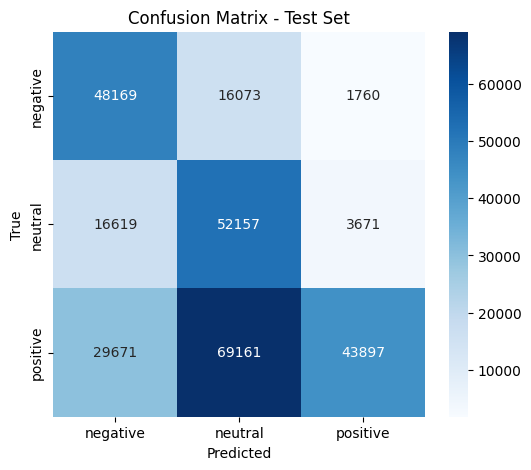

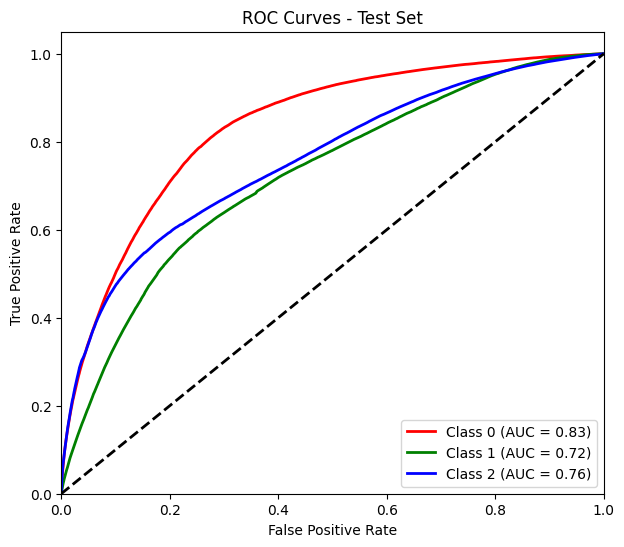

RoBERTa inference:   0%|          | 0/87868 [00:00<?, ?it/s]

Saved full dataset predictions to bert_sentiment_full.csv


In [9]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import pandas as pd
import numpy as np

# ✅ Device check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
torch.backends.cudnn.benchmark = True   # speedup on GPU

# ✅ Use Twitter RoBERTa (3-class sentiment: negative, neutral, positive)
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
model.to(device)
model.eval()
model.half()   # FP16 for speed/memory

# ✅ Prediction function
@torch.inference_mode()
def predict_labels(texts, batch_size=32, max_length=128):
    preds, confs, probs_all = [], [], []
    for i in tqdm(range(0, len(texts), batch_size), desc="RoBERTa inference"):
        batch = texts[i:i+batch_size]
        enc = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        ).to(device)

        outputs = model(**enc)
        probs = torch.softmax(outputs.logits, dim=-1)
        conf, ids = torch.max(probs, dim=-1)
        preds.extend(ids.cpu().numpy())
        confs.extend(conf.cpu().numpy())
        probs_all.extend(probs.cpu().numpy())
    return preds, confs, np.array(probs_all)

# ✅ Run on Validation and Test
val_texts = list(X_val)
test_texts = list(X_test)

val_preds, _, val_probs = predict_labels(val_texts, batch_size=32)
test_preds, _, test_probs = predict_labels(test_texts, batch_size=32)

# ✅ Map string labels to numeric
label2id = {"negative":0, "neutral":1, "positive":2}
y_val_mapped = [label2id[str(l).lower()] for l in y_val]
y_test_mapped = [label2id[str(l).lower()] for l in y_test]

# ✅ Metrics
print("\nValidation Evaluation:")
print("Accuracy:", accuracy_score(y_val_mapped, val_preds))
print("Macro-F1:", f1_score(y_val_mapped, val_preds, average="macro"))
print("Classification Report:\n", classification_report(y_val_mapped, val_preds, target_names=["negative","neutral","positive"]))

print("\nTest Evaluation:")
print("Accuracy:", accuracy_score(y_test_mapped, test_preds))
print("Macro-F1:", f1_score(y_test_mapped, test_preds, average="macro"))
print("Classification Report:\n", classification_report(y_test_mapped, test_preds, target_names=["negative","neutral","positive"]))

# ✅ Confusion Matrix (Test set)
cm = confusion_matrix(y_test_mapped, test_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["negative","neutral","positive"], yticklabels=["negative","neutral","positive"])
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ✅ ROC Curve (One-vs-Rest, Test set)
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test_mapped, classes=[0,1,2])
fpr, tpr, roc_auc = {}, {}, {}

for i in range(3):  # 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(7,6))
for i, color in zip(range(3), ["red","green","blue"]):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],"k--", lw=2)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Test Set")
plt.legend(loc="lower right")
plt.show()

# ✅ Full dataset inference (optional)
all_preds, all_confs, _ = predict_labels(df['clean_text'].tolist(), batch_size=32)
df['bert_label'] = all_preds
df['bert_conf'] = all_confs
df.to_csv("bert_sentiment_full.csv", index=False)
print("Saved full dataset predictions to bert_sentiment_full.csv")
